In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import naludaq
print(f"Naludaq version: {naludaq.__version__}")

FTDI import failed: FTDI driver not installed
D3XX import failed: D3XX driver not installed


Naludaq version: 0.31.7


In [2]:
from naludaq.backend import DiskAcquisition

ACQ_PATH = "data/SineWave_100MHz/"      # 200mV
channels = 4
# DiskAcquisition is recommended to be used as a context manager for safety
with DiskAcquisition(ACQ_PATH) as acq:
    print("Board model:", acq.params["model"])
    print("Number of events:", len(acq))
    print("Pedestals stored:", acq.pedestals is not None)

acq= DiskAcquisition(ACQ_PATH)

from naludaq.tools.pedestals.pedestals_correcter import PedestalsCorrecter
pedestals=acq.pedestals
params = acq.params
corrector = PedestalsCorrecter(params, pedestals)

Board model: dsa-c10-8
Number of events: 1013
Pedestals stored: True


Event number: 777


Text(0, 0.5, 'ADC Count')

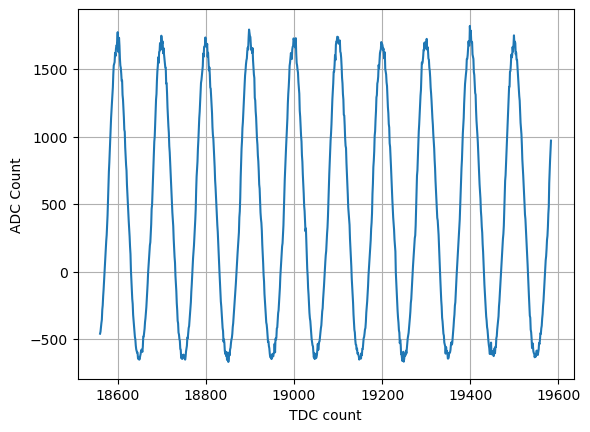

In [3]:
# event_num=np.random.randint(0, 1012)
event_num = 777
print("Event number: {}".format(event_num))
event=acq[event_num]
corrected_event = corrector.run(event, correct_in_place=True)
time=corrected_event["time"]
adc=corrected_event["data"]
plt.plot(time[4],adc[4],label="Ch. 4")
plt.grid()
plt.xlabel("TDC count")
plt.ylabel("ADC Count")

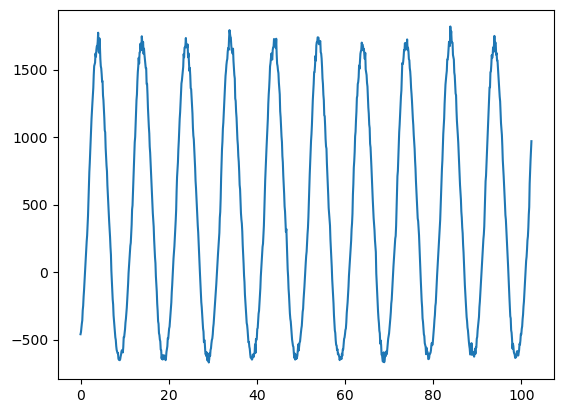

In [4]:
time_adjusted = time[4] - time[4][0]
time_adjusted = time_adjusted * 0.1
plt.plot(time_adjusted,adc[4],label="Ch. 4")

In [5]:
print(time_adjusted)

[0.000e+00 1.000e-01 2.000e-01 ... 1.021e+02 1.022e+02 1.023e+02]


Fitted parameters: A=1170.967, f=0.100, phi=-0.944, C=445.830


Text(0, 0.5, 'ADC Count')

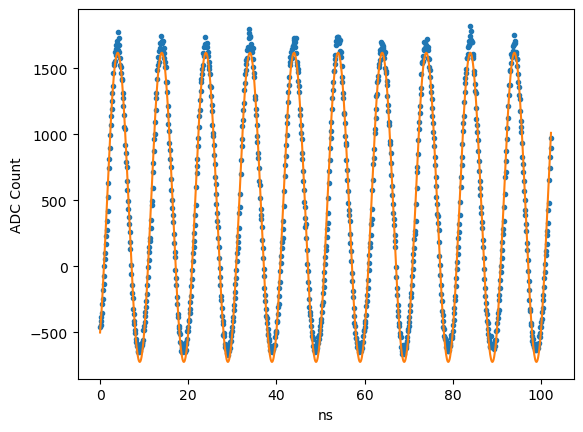

In [6]:
def sinewave(x, A, f, phi, c):
    return A * np.sin(2 * np.pi * f * x + phi) + c

p, _ = curve_fit(sinewave, time_adjusted, adc[4], p0=[2500, 0.1, 0, 0])

A_fit, f_fit, phi_fit, C_fit = p
print(f"Fitted parameters: A={A_fit:.3f}, f={f_fit:.3f}, phi={phi_fit:.3f}, C={C_fit:.3f}")

plt.plot(time_adjusted, adc[4], '.', label="Data")
plt.plot(time_adjusted, sinewave(time_adjusted, *p), label="Fit")
plt.xlabel("ns")
plt.ylabel("ADC Count")

Problem was the frequency. Of course the waveform is at 100 MHz, but from the data, from the time values that are in nanoseconds, if you input 100.000.000 it understands the x axis as seconds and shows nothing of course. Instead, if you consider that there is a point each 0.1 nanoseconds, the frequency in nanoseconds is exactly 0.1.

In [7]:
corrections = []
for i in range(len(time_adjusted)):
    corrections.append(adc[4][i]-sinewave(time_adjusted, *p)[i])
    
print(corrections)

[41.82021402337091, 12.001941519704701, -3.6807134544748124, -25.036010275514172, -55.958897551722316, -40.23182239741368, -67.02558904646207, -63.90026341667976, -80.10612005498797, -84.38462772608489, -83.26946975479257, -96.48759509511694, -121.86029597776928, -129.30430788301936, -142.93292749762242, -173.55714424359257, -178.18678091303752, -174.2316389073111, -136.3026435605966, -102.61298502767022, -65.27925023312605, -66.6225414146063, -48.5695768454957, -16.35376939286914, -5.816278653965128, 4.492967481281994, -1.2857141265753853, 8.377289677624503, 13.899982131970773, 17.58789616652325, 68.0332832287877, 92.81435452706592, 68.79457768626526, 47.02203159204123, 85.82882196950868, 37.33056000304532, 68.82590605491941, 78.49618028353439, 65.00504169806572, 91.59823691615657, 156.90341961625313, 21.330041397138302, 17.769314475411647, 135.4942463681375, 92.6597464237775, 19.502803780959766, -9.057263947252068, 3.781507754918266, -5.895882778486566, -23.420949519361557, 20.958800

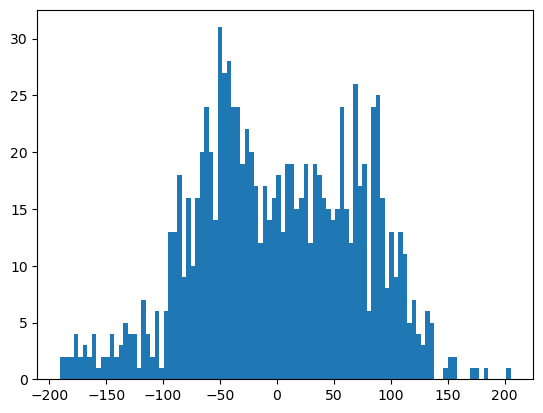

In [8]:
plt.hist(corrections, bins=100);

In [9]:
# Here I am trying to create a 2D array with the corrections for each cell
# The array is 128x8, where each row corresponds to a cell because the cycle loops over the 128 cells 8 times
cell_corr = np.zeros((128, 8))

for i in range(128):
    for j in range(8):
        cell_corr[i][j] = corrections[j*128+i]

print(cell_corr)

[[ 41.82021402  16.90685719 -62.64863833 ...  68.60277094  46.1429745
   37.57192371]
 [ 12.00194152  67.10116821 -26.86308155 ...  56.28058668  29.13939574
   56.76654233]
 [ -3.68071345  90.55329455 -24.74751668 ...  32.47085423  -5.21215572
   20.67926138]
 ...
 [-39.11704957 -29.07745782  21.6799994  ... -48.48461399  77.62921074
  -48.28621181]
 [ -7.29050664 -19.44044094  62.97407419 ...   5.64305885  84.59288912
  -49.69939123]
 [ 28.37813528 -64.45441863  60.82001244 ...  25.28193871  99.38014097
  -39.94487408]]


## Now, let's try to make this automatic and average for the whole sample of waveforms in order to get a good statistical correction

In [10]:
ev_corrections = np.zeros((len(acq), len(time_adjusted)))

for ev in range(len(acq)):
    event=acq[ev]
    corrected_event = corrector.run(event, correct_in_place=True)
    time=corrected_event["time"]
    adc=corrected_event["data"]
    time_adjusted = (time[4] - time[4][0]) * 0.1
    p, _ = curve_fit(sinewave, time_adjusted, adc[4], p0=[2500, 0.1, 0, 0])
    ev_corrections[ev] = adc[4] - sinewave(time_adjusted, *p)
    # This is python vectorisation, it is much faster than looping over the array (2.9s vs 23.6s)
    # for i in range(len(time_adjusted)):
        # ev_corrections[ev][i] = adc[4][i]-sinewave(time_adjusted, *p)[i]

print(ev_corrections)

[[   9.66547812 -159.25673158  398.32164539 ... -436.96275517
  -301.56138912   68.62406283]
 [   2.69221196  -26.9764179   -60.75816576 ...   32.88475626
    26.09289593  -46.64699784]
 [ -24.98850936   -2.04666675    2.42041262 ...   43.34325894
     2.49584935    5.61053134]
 ...
 [ -74.76461657 -101.12167218 -110.39313802 ...   72.1629203
    37.27776145   53.38023511]
 [ -21.82689871  -36.86668835   -1.44693856 ...   46.9501907
    28.19628307   37.02736405]
 [ -14.97944533  -13.80852541   36.20108388 ...   70.43414323
    -9.187617     51.79374393]]


In [11]:
# Just to check I retrive the same data as befor when I was doing it event by event
print(ev_corrections[138][0])
print(corrections[0])
print(ev_corrections.shape)

25.426823669284715
41.82021402337091
(1013, 1024)


In [12]:
print(len(ev_corrections[:,0]))
# Good, these are all the values of point 0 in all events

1013


In [13]:
# Now I will average the corrections for each point in time (considering the naive assumptions that we havee 1024 cells instead of 128 looping 8 times)
# This will give me the final correction to be applied to the data (with 1024 points though). 
# To be more precise I should consider the corrections only for the 128 cells,there is even more statistics
final_correction = np.zeros(1024)
for i in range(len(time_adjusted)):
    final_correction[i] = np.mean(ev_corrections[:,i])
print(final_correction)

[-12.19075519 -11.99307193  -9.03138487 ...   8.47834012  11.20945639
   5.4312021 ]


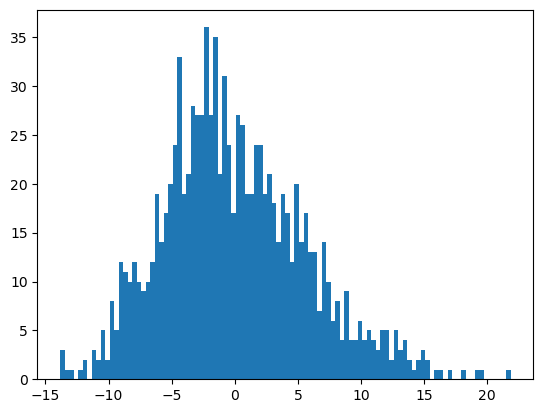

In [14]:
# Visualizing the final correction factors
plt.hist(final_correction, bins=100);

## Now I'll try to calibrate only the 128 cells

In [15]:
cell_corr = np.zeros((len(acq), 128, 8))

for ev in range(len(acq)):
    event=acq[ev]
    corrected_event = corrector.run(event, correct_in_place=True)
    time=corrected_event["time"]
    adc=corrected_event["data"]
    time_adjusted = (time[4] - time[4][0]) * 0.1
    p, _ = curve_fit(sinewave, time_adjusted, adc[4], p0=[2500, 0.1, 0, 0])
    corr_values = adc[4]-sinewave(time_adjusted, *p)
    cell_corr[ev] = corr_values.reshape(8, 128).T
    # This last line is a vectorisation of the nested loop I used before to fill the cell_corr array
    # Instead of using this I can use .reshape()
    # for i in range(128):
        # for j in range(8):
            # cell_corr[ev][i][j] = corr_values[j*128+i]

In [16]:
# Check if it is matching the previous result
print(cell_corr.shape)
print(cell_corr[179][-1][2])

(1013, 128, 8)
82.00603866390708


In [17]:
# Now we have to average on each cell
# In the end we need 1 dimensional 128 points array for the 128 cells

# final_cell_correction = np.zeros((128))
# for i in range(128):
    # final_cell_correction[i] = np.mean(cell_corr[:,i,:])
# print(final_cell_correction)

final_cell_correction = np.mean(cell_corr, axis=(0, 2))
print(final_cell_correction)

[-4.08391887 -2.85529917 -1.18778877 -6.39754223  0.34231783 -4.57727054
 -2.42977375 -3.30793456 -0.77738507 -2.48668865 -4.58524201 -0.77302579
 -4.87243046 -3.95268595  1.41198478 -1.20217734  1.64140713 -6.87548167
  6.56804426  3.82029806 -3.1303187   4.2758689  -3.74779667  8.97952997
  4.0823597   0.33953279 -0.83236297 -4.2239184  -2.67032659 -3.12260494
 -1.73146521  2.40377413  0.8149034  -4.98170931  1.11511773 -3.92875707
 -1.80196086 -5.31696629 -5.18241306 -4.68069865 -0.86523855 -6.22730958
 -3.63461108  2.90936923 -2.93337415 -0.86214189  4.06527057 -3.11066573
 -8.17922522 -2.90276556 -8.09419695 -7.40473044 -5.08498519 -6.87228055
 -2.02970513 -1.92760946  5.02525902 -2.11949268 -1.83884915 -2.90112366
 13.2459841  -0.02707031  6.86544614  1.23982989  1.29560332  1.07775282
  2.19906055  7.7918538  -2.03311336  3.02167862 -1.65272596  5.8226617
  7.71990543  7.54667595  1.69744523  7.86272629  5.82239511  0.90071044
 -0.39849588  7.9956543  -1.677806   -1.3585935  15.

## Now we see if we can apply the corrections to a random event

### First the naive corrections on the 1024 points

In [18]:
def apply_corr(ev, corr):
    event=acq[ev]
    corrected_event = corrector.run(event, correct_in_place=True)
    time=corrected_event["time"]
    adc=corrected_event["data"]
    time_adjusted = (time[4] - time[4][0]) * 0.1
    for i in range(len(time_adjusted)):
        adc[4][i] = adc[4][i] - corr[i]
    plt.plot(time_adjusted, adc[4], '.', label="Ch. 4")
    return time_adjusted, adc[4]

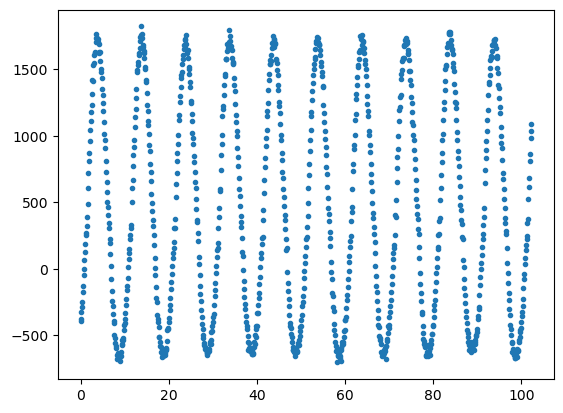

In [19]:
apply_corr(138, final_correction);

### Then the single cell correction

In [20]:
def apply_cell_corr(ev, corr):
    event=acq[ev]
    corrected_event = corrector.run(event, correct_in_place=True)
    time=corrected_event["time"]
    adc=corrected_event["data"]
    time_adjusted = (time[4] - time[4][0]) * 0.1
    for i in range(len(time_adjusted)//128):
        for j in range(128):
            adc[4][128*i + j] = adc[4][128*i + j] - corr[j]
    plt.plot(time_adjusted, adc[4], '.', label="Ch. 4")
    return time_adjusted, adc[4]

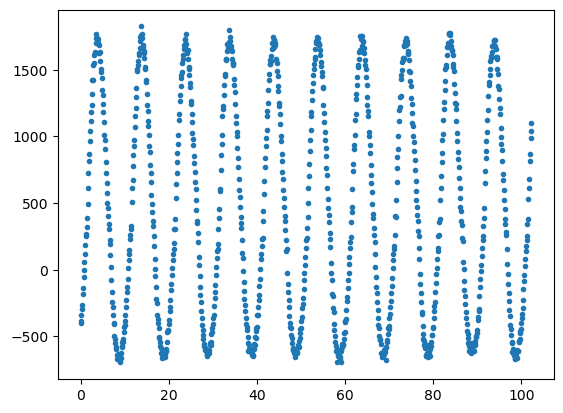

In [21]:
apply_cell_corr(138, final_cell_correction);

## Try to apply this correction coming from the sinewave to some pulses

In [22]:
ACQ_PATH1 = "data/Pulse_test_2/"
channels1 = [0,1]
# DiskAcquisition is recommended to be used as a context manager for safety
with DiskAcquisition(ACQ_PATH1) as acq1:
    print("Board model:", acq1.params["model"])
    print("Number of events:", len(acq1))
    print("Pedestals stored:", acq1.pedestals is not None)

acq1= DiskAcquisition(ACQ_PATH1)

from naludaq.tools.pedestals.pedestals_correcter import PedestalsCorrecter
pedestals1=acq1.pedestals
params1 = acq1.params
corrector1 = PedestalsCorrecter(params1, pedestals1)

Board model: dsa-c10-8
Number of events: 501
Pedestals stored: True


Event number: 77


Text(0, 0.5, 'ADC Count')

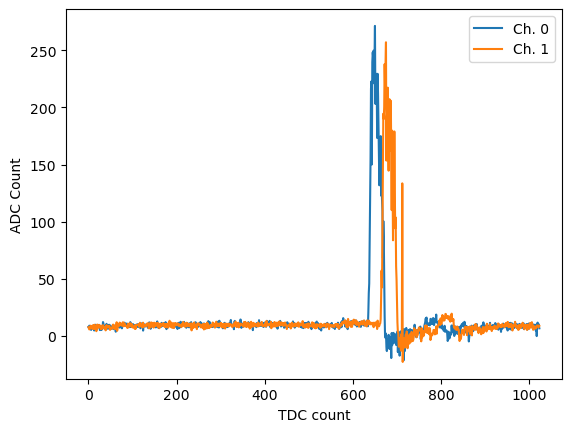

In [23]:
event_num = 77
print("Event number: {}".format(event_num))
event1=acq1[event_num]
corrected_event1 = corrector1.run(event1, correct_in_place=True)
time1=corrected_event1["time"]
adc1=corrected_event1["data"]
for ch in channels1:
    plt.plot(time1[ch],adc1[ch],label=f"Ch. {ch}")
plt.legend()
plt.xlabel("TDC count")
plt.ylabel("ADC Count")

In [24]:
def apply_corr_pulse(ev, corr):
    event=acq1[ev]
    corrected_event = corrector1.run(event, correct_in_place=True)
    time=corrected_event["time"]
    adc=corrected_event["data"]
    time_adjusted = (time[0] - time[0][0]) * 0.1
    for i in range(len(time_adjusted)):
        adc[0][i] = adc[0][i] - corr[i]
    plt.plot(time[0], adc[0], label="Correction")
    return time_adjusted, adc[0]

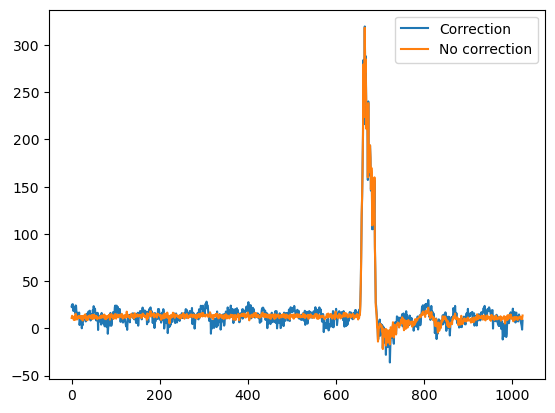

In [25]:
# Plot the pulse applying the correction from the sine wave
apply_corr_pulse(277, final_correction);

# Also, for reference, plot the pulse without the correction
event=acq1[277]
corrected_event1 = corrector1.run(event, correct_in_place=True)
time1=corrected_event1["time"]
adc1=corrected_event1["data"]
time_adjusted1 = (time1[0] - time1[0][0]) * 0.1
plt.plot(time1[0], adc1[0], label="No correction")
plt.legend()

Here it doesn't work. The data without the calibration factors are better than the corrected ones. Actually, makes sense from a visual point of view: while the sinewaves whre clearly not perfect, here the pedestal was already been corrected. Let's continue saying that it's fine for now.